
# Exporting Dataset

Exporting and extrating dataset from google drive to the work folder


In [ ]:
!unzip /content/drive/MyDrive/EyeDiseaseDataset.zip

Archive:  /content/drive/MyDrive/EyeDiseaseDataset.zip
  inflating: dataset/cataract/0_left.jpg  
  inflating: dataset/cataract/103_left.jpg  
  inflating: dataset/cataract/1062_right.jpg  
  inflating: dataset/cataract/1083_left.jpg  
  inflating: dataset/cataract/1084_right.jpg  
  inflating: dataset/cataract/1102_left.jpg  
  inflating: dataset/cataract/1102_right.jpg  
  inflating: dataset/cataract/1115_left.jpg  
  inflating: dataset/cataract/1126_right.jpg  
  inflating: dataset/cataract/112_right.jpg  
  inflating: dataset/cataract/1144_left.jpg  
  inflating: dataset/cataract/1144_right.jpg  
  inflating: dataset/cataract/1164_left.jpg  
  inflating: dataset/cataract/1167_right.jpg  
  inflating: dataset/cataract/119_left.jpg  
  inflating: dataset/cataract/1285_left.jpg  
  inflating: dataset/cataract/1415_left.jpg  
  inflating: dataset/cataract/1415_right.jpg  
  inflating: dataset/cataract/1435_left.jpg  
  inflating: dataset/cataract/1444_left.jpg  
  inflating: dataset/ca

# Importing Libraries

In [ ]:
import numpy as np
import pandas as pd
import os
import pathlib
import tensorflow as tf
import seaborn as sn
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical, plot_model, image_dataset_from_directory
from tensorflow.keras import regularizers
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, BatchNormalization, Dropout, RandomContrast, RandomRotation, RandomZoom, RandomFlip

# Setting Dataset path

In [ ]:
data_dir = pathlib.Path("/content/dataset")
data = image_dataset_from_directory(data_dir, seed = 123, image_size=(224, 224))
class_names = data.class_names

Found 4217 files belonging to 4 classes.


# Data Distribution

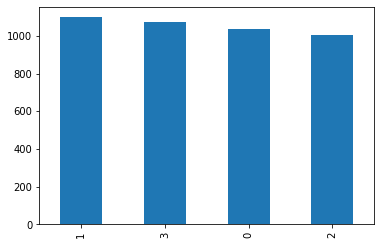

In [ ]:
labels = np.concatenate([y for x,y in data], axis=0)
values = pd.value_counts(labels)
values.plot(kind='bar')

# Image Samples Checking

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


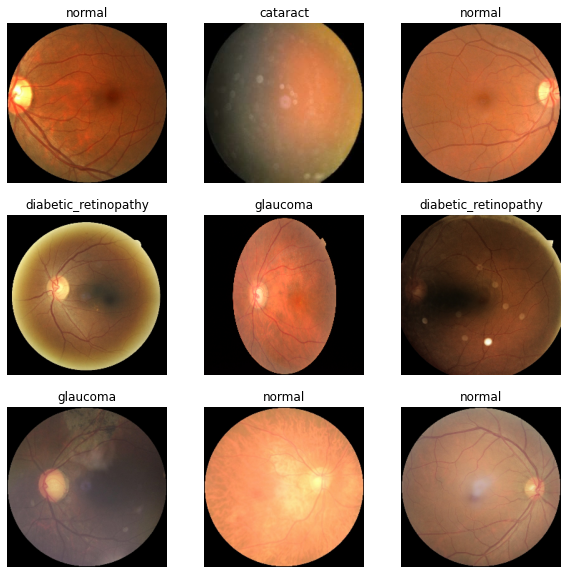

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in data.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(data.class_names[labels[i]])
        plt.axis("off")

# Splitting Data


* 70% for training
* 20% for validating
* 10% for testing

In [ ]:
data = data.map(lambda x, y: (x/255, y))
train_size = int(0.7 * len(data)) +1
val_size = int(0.2 * len(data))
test_size = int(0.1 * len(data))
train = data.take(train_size)
remaining = data.skip(train_size)
val = remaining.take(val_size)
test = remaining.skip(val_size)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [ ]:
test_iter = test.as_numpy_iterator()
test_set = {"images":np.empty((0,224,224,3)), "labels":np.empty(0)}
while True:
    try:
        batch = test_iter.next()
        test_set['images'] = np.concatenate((test_set['images'], batch[0]))
        test_set['labels'] = np.concatenate((test_set['labels'], batch[1]))
    except:
        break
y_test = test_set['labels']

In [ ]:
def evaluate_model(model):
    model.evaluate(test)
    y_pred = np.argmax(model.predict(test_set['images']), 1)
    print(classification_report(y_test, y_pred, target_names = class_names))
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 8))
    sn.heatmap(cm, annot=True)
    plt.xticks(np.arange(4)+.5, class_names, rotation=90)
    plt.yticks(np.arange(4)+.5, class_names)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")

# Create the CNN Model

In [ ]:
model = Sequential([
        Conv2D(64, (3,3), activation = 'relu',padding='same', input_shape=(224,224,3)),
        Conv2D(64, (3,3), activation = 'relu',padding='same'),
        Conv2D(64, (3,3), activation = 'relu',padding='same'),
        MaxPool2D(),
        Conv2D(128, (3,3), padding='same', activation = 'relu'),
        Conv2D(128, (3,3),padding='same', activation = 'relu'),
        Conv2D(128, (3,3), activation = 'relu',padding='same'),
        MaxPool2D(),
        Flatten(),
        Dense(256, activation = 'relu'),
        Dense(4, activation='softmax')
    ])
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Checking the Summary Before Starting The Training

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 conv2d_2 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 64)     0         
 )                                                               
                                                                 
 conv2d_3 (Conv2D)           (None, 112, 112, 128)     73856     
                                                                 
 conv2d_4 (Conv2D)           (None, 112, 112, 128)     147584    
                                                        

### Ploting the model

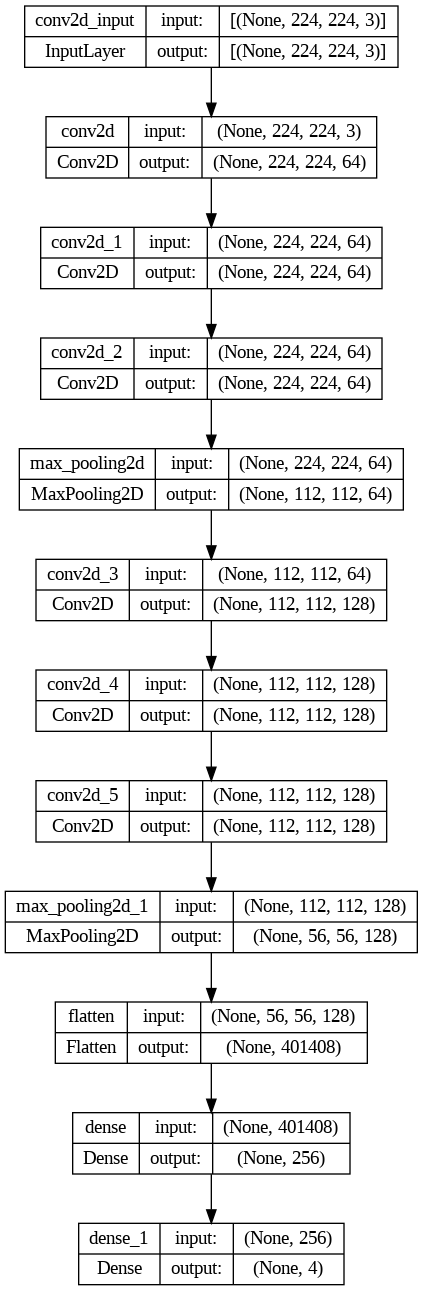

In [ ]:
plot_model(model, to_file='simple-cnn.png', show_shapes=True)

# Training the Model

In [ ]:
history = model.fit(train, validation_data=val, epochs = 10)

Epoch 1/10
93/93 [==============================] - 67s 547ms/step - loss: 1.2453 - accuracy: 0.4741 - val_loss: 0.8098 - val_accuracy: 0.6454
Epoch 2/10
93/93 [==============================] - 73s 773ms/step - loss: 0.7606 - accuracy: 0.6573 - val_loss: 0.9614 - val_accuracy: 0.5529
Epoch 3/10
93/93 [==============================] - 52s 546ms/step - loss: 0.6510 - accuracy: 0.7194 - val_loss: 0.6049 - val_accuracy: 0.7560
Epoch 4/10
93/93 [==============================] - 52s 547ms/step - loss: 0.5956 - accuracy: 0.7278 - val_loss: 0.5898 - val_accuracy: 0.7512
Epoch 5/10
93/93 [==============================] - 53s 548ms/step - loss: 0.5730 - accuracy: 0.7429 - val_loss: 0.5157 - val_accuracy: 0.7788
Epoch 6/10
93/93 [==============================] - 53s 548ms/step - loss: 0.5099 - accuracy: 0.7755 - val_loss: 0.3874 - val_accuracy: 0.8329
Epoch 7/10
93/93 [==============================] - 51s 534ms/step - loss: 0.3687 - accuracy: 0.8461 - val_loss: 0.3662 - val_accuracy: 0.8365

# Check the performance of the Model

In [ ]:
def plot_performance(epochs, history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

# Ploting Graphs

*   Training and Validation Accuracy Graph
*   Training and Validation Loss Graph



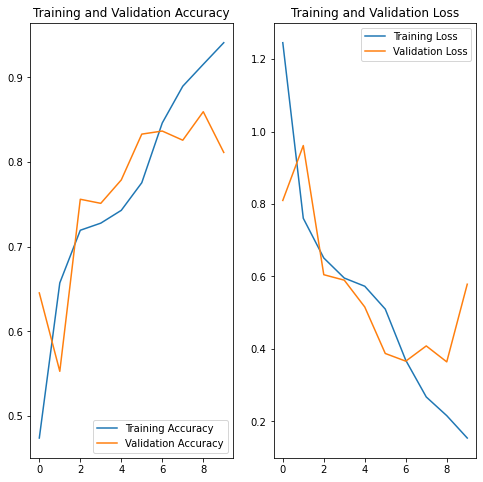

In [ ]:
plot_performance(10, history)

# Evaluating the Model

13/13 [==============================] - 1s 94ms/step
                      precision    recall  f1-score   support

            cataract       0.75      0.91      0.83        91
diabetic_retinopathy       0.86      0.99      0.92       109
            glaucoma       0.70      0.60      0.65       103
              normal       0.85      0.68      0.75       106

            accuracy                           0.79       409
           macro avg       0.79      0.80      0.79       409
        weighted avg       0.79      0.79      0.79       409



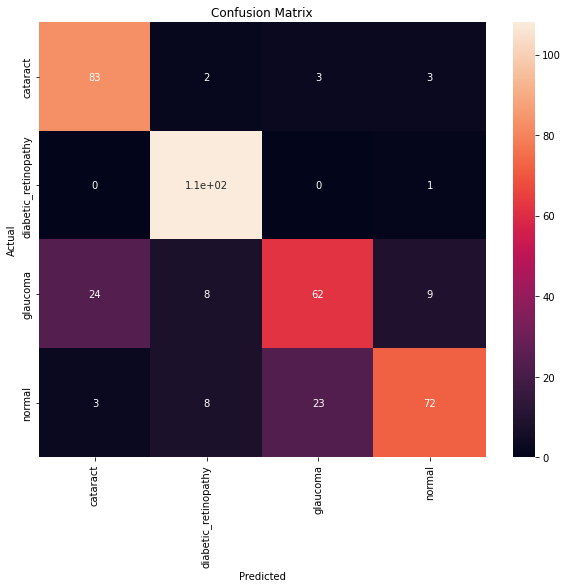

In [ ]:
evaluate_model(model)